<h1>Лабораторная работа №3<h1>
<h2>Выполнил: Тимофеев Илья<h2>
<h2>Группа: ББМО-01-22<h2/>

 **Шаг 1**
Выполним импорт библиотек.

In [1]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.5 MB/s eta 0:00:00


In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 23s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

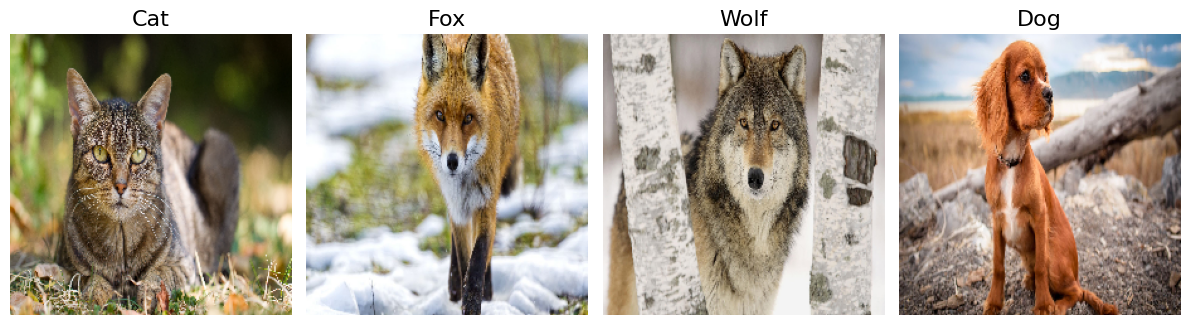

In [12]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Заголовки наших изображений
image_titles = ['Cat', 'Fox', 'Wolf', 'Dog']

# Загружаем изображения и конвертируем их в массив Numpy
img1 = load_img('cat.jpeg', target_size=(224, 224))
img2 = load_img('fox.jpeg', target_size=(224, 224))
img3 = load_img('wolf.jpeg', target_size=(224, 224))
img4 = load_img('dog.jpeg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Подготавливаем входы для VGG16
X = preprocess_input(images)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [13]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [14]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([386, 285, 330, 134])
# Где: 386 - кот, 285 - лис, 330 - волк, 134 - собака

# Вместо использования объекта CategoricalScore
# определим функцию с нуля следующим образом:
def score_function(output):
    # Переменная `output` ссылается на выходы модели,
    # таким образом, что размерность `output` равна `(3, 1000)` где, (номер примера, номер класса)
    return (output[0][386], output[1][285], output[2][330], output[3][134])

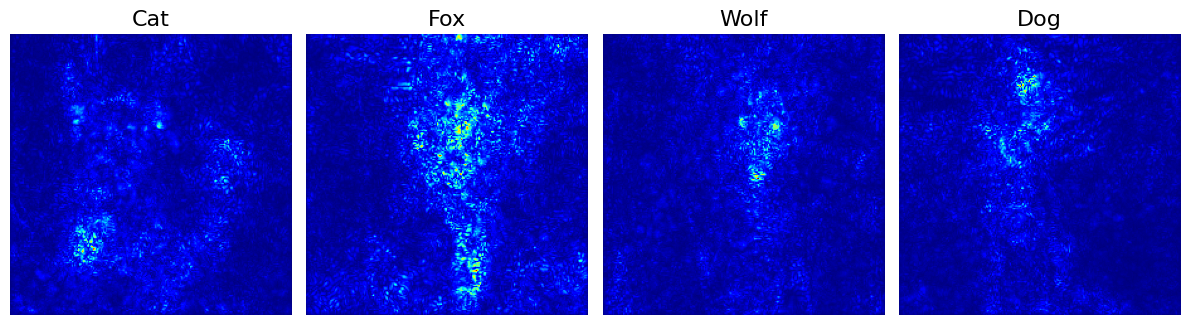

CPU times: user 6.53 s, sys: 1.19 s, total: 7.72 s
Wall time: 9.25 s


In [15]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Создаем объект внимания
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Генерируем карту внимания
saliency_map = saliency(score, X)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

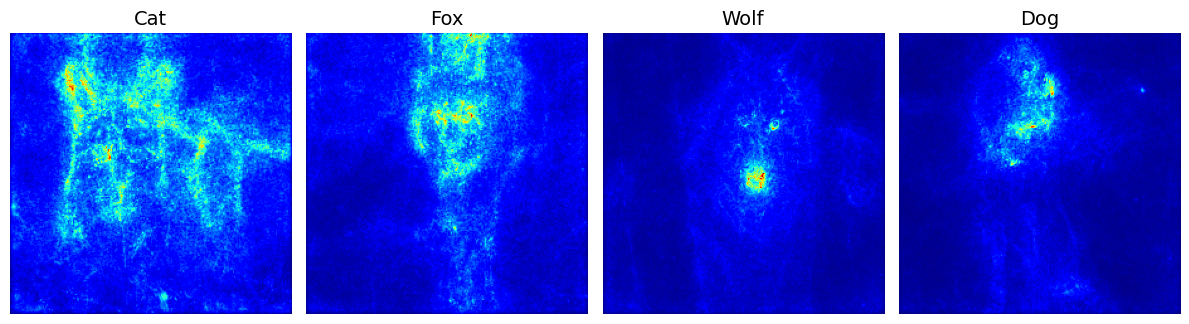

CPU times: user 2.15 s, sys: 265 ms, total: 2.42 s
Wall time: 3.55 s


In [16]:
%%time

# Генерируем карту внимания со сглаживанием, которое уменьшает шум за счет добавления шума
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # Количество итераций расчета градиентов
                        smooth_noise=0.20) # уровень распространения шума

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

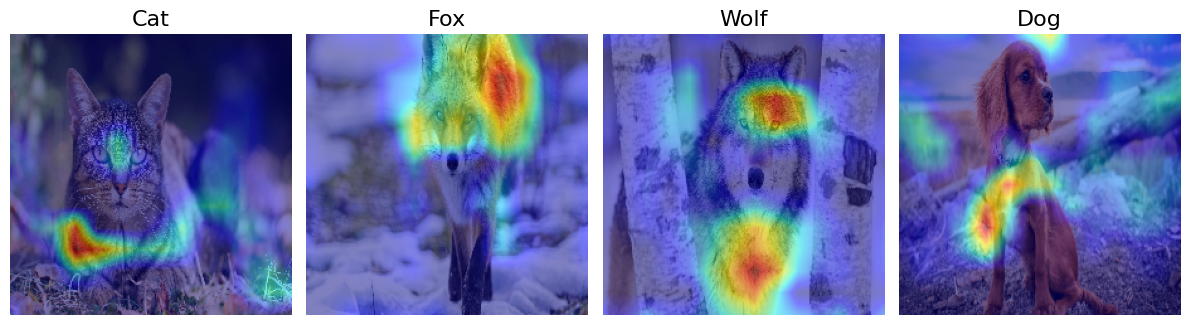

CPU times: user 1.52 s, sys: 868 ms, total: 2.38 s
Wall time: 2.29 s


In [17]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Создаём объект визуализации Gradcam
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Генерируем тепловую карту с помощью GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

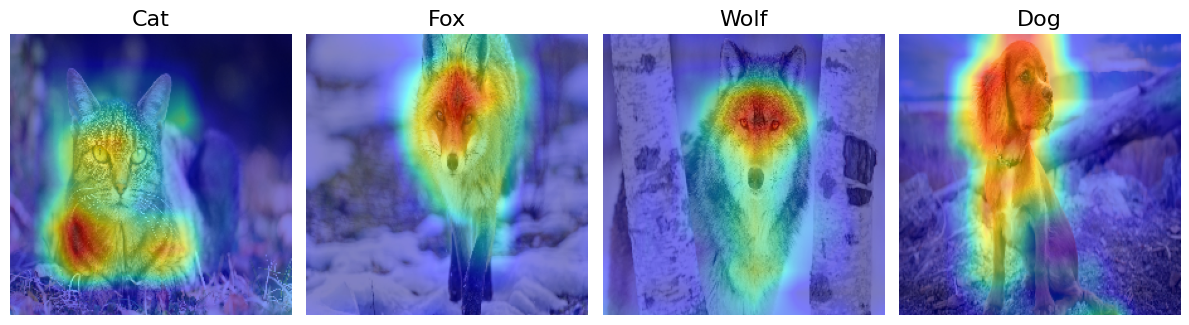

CPU times: user 2.45 s, sys: 1.04 s, total: 3.49 s
Wall time: 4.15 s


In [18]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Создаем объект GradCAM++
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)
# Генерируем тепловую карту с помощью GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)
# Визуализируем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()